In [156]:
import pandas as pd
import numpy as np
from sklearn import *
import matplotlib.pyplot as plt
%matplotlib inline

## First load, shape and merge the data

In [217]:
#load data
filename1 = '/Users/jamesledoux/Documents/USElection-master/data/2004-pres-polls.csv'
filename2 = '/Users/jamesledoux/Documents/USElection-master/data/2008-pres-polls.csv'
filename3 = '/Users/jamesledoux/Documents/USElection-master/data/2012-pres-polls.csv'
filename4 = '/Users/jamesledoux/Documents/USElection-master/data/electoral-college-votes.csv'
filename5 = '/Users/jamesledoux/Documents/USElection-master/data/state-abbreviations.csv'

df04 = pd.read_csv(filename1)
df08 = pd.read_csv(filename2)
df12 = pd.read_csv(filename3)
electoral_college = pd.read_csv(filename4,names=['State', 'Votes'])
state_abbreviations = pd.read_csv(filename5,names=['State', 'Abbrev'])
#see format
#print df12.head()
#print electoral_college.head()

In [218]:
#fix state names for later merging
df04 = pd.merge(df04, state_abbreviations, left_on = 'State', right_on = 'Abbrev')
df08 = pd.merge(df08, state_abbreviations, left_on = 'State', right_on = 'Abbrev')
df04 = df04.drop('State_x',1)
df08 = df08.drop('State_x',1)
df04.columns = ['Kerry', 'Bush', 'Date', 'Pollster', 'State', 'Abbrev']
df08.columns = ['Obama', 'McCain', 'Date', 'Pollster', 'State', 'Abbrev']

#merge in electoral college info
df04 = pd.merge(df04, electoral_college, left_on = 'State', right_on = 'State')
df08 = pd.merge(df08, electoral_college, left_on = 'State', right_on = 'State')
df12 = pd.merge(df12, electoral_college, left_on = 'State', right_on = 'State')

In [219]:
#df12.head()

In [220]:
#take a simple average for each state
df04a = df04.groupby('State').mean()
df08a = df08.groupby('State').mean()
df12a = df12.groupby('State').mean()

In [221]:
#see what this means for a prediction 
df04a['DemVotes'] = 0
df04a['GOPVotes'] = 0
df08a['DemVotes'] = 0
df08a['GOPVotes'] = 0
df12a['DemVotes'] = 0
df12a['GOPVotes'] = 0

df04a['DemVotes'] = np.where(df04a['Kerry'] > df04a['Bush'], df04a['Votes'], 0)
df04a['GOPVotes'] = np.where(df04a['Kerry'] < df04a['Bush'], df04a['Votes'], 0)
df08a['DemVotes'] = np.where(df08a['Obama'] > df08a['McCain'], df08a['Votes'], 0)
df08a['GOPVotes'] = np.where(df08a['Obama'] < df08a['McCain'], df08a['Votes'], 0)
df12a['DemVotes'] = np.where(df12a['Dem'] > df12a['GOP'], df12a['Votes'], 0)
df12a['GOPVotes'] = np.where(df12a['Dem'] < df12a['GOP'], df12a['Votes'], 0)

## Assign electoral votes based on polling averages, and sum these up for a basic election prediction

In [222]:
dems04 = df04a['DemVotes'].sum()
GOP04 = df04a['GOPVotes'].sum()
dems08 = df08a['DemVotes'].sum()
GOP08 = df08a['GOPVotes'].sum()
dems12 = df12a['DemVotes'].sum()
GOP12 = df12a['GOPVotes'].sum()

In [223]:
print "2004 dems: " + str(dems04) + "  republicans: " + str(GOP04)
print "2008 dems: " + str(dems08) + "  republicans: " + str(GOP08)
print "2012 dems: " + str(dems12) + "  republicans: " + str(GOP12)



2004 dems: 247.0  republicans: 291.0
2008 dems: 303.0  republicans: 235.0
2012 dems: 332.0  republicans: 206.0


Results align with reality, so this basic model seems okay. However, this takes all polling into account, so this would not be a feasible predictive model at an earlier point in the election cycle. Let's see how well this same strategy works in a more realistic time-series approach. 

# Time Series
Let's turn this into something more realistic. First we need to turn the polls' dates into datetime types in order to calculate election odds at specific points in time. Then we can look at running predictions and see how those change over time.

In [224]:
df04['Date'] = pd.to_datetime(df04['Date'], format='%b %d')

In [225]:
#break this into slices of times <= month M for M in 1, ..., 12.
#predict per month, add prediction to a data frame of predicted R and D electoral votes by month
#plot

In [226]:
df04b = df04[df04['Date'] < '1900-6-04 00:00:00']

In [227]:
months = ['May', 'June', 'July', 'August', 'September', 'October', 'November']
ds = []
rs = []
for i in range(len(months)):
    datestring = '1900-' + str(i+5) + '-15 00:00:00'
    #datestring = '1900-15-' + str(i+5) + ' 00:00:00'
    df04b = df04[df04['Date'] < datestring]   #df of all polls prior to this date
    df04b = df04b.groupby('State').mean()  #get mean by state
    print df04b.shape
    #assign all R and D votes to highest polling candidate by state 
    df04b['DemVotes'] = 0
    df04b['GOPVotes'] = 0
    df04b['DemVotes'] = np.where(df04b['Kerry'] > df04b['Bush'], df04b['Votes'], 0)
    df04b['GOPVotes'] = np.where(df04b['Kerry'] < df04b['Bush'], df04b['Votes'], 0)
    ds.append(df04b['DemVotes'].sum())  #sum total predicted dem and republican votes
    rs.append(df04b['GOPVotes'].sum())   

(13, 3)
(42, 3)
(43, 3)
(44, 3)
(50, 3)
(51, 3)
(51, 3)


([<matplotlib.axis.XTick at 0x108aac410>,
 <a list of 7 Text xticklabel objects>)

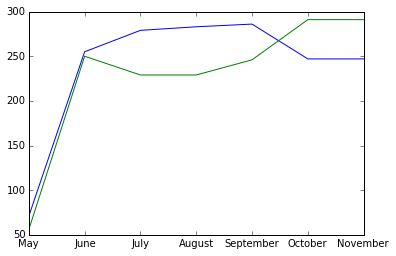

In [228]:
x= [0,1,2,3,4,5,6]
plt.plot(x, ds)
plt.plot(x, rs)
plt.xticks(x, months)

# Same thing, but looking into 2008

In [229]:
df08['Date'] = pd.to_datetime(df08['Date'], format='%b %d')

In [252]:
months = ['Feb', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November']
ds = []
rs = []
for i in range(len(months)):
    if (i+5) < 10:  #formatting
        datestring = '1900-0' + str(i+2) + '-15 00:00:00'
    else:
        datestring = '1900-' + str(i+2) + '-15 00:00:00'
    #datestring = '1900-15-' + str(i+5) + ' 00:00:00'
    df08b = df08[df08['Date'] < datestring]   #df of all polls prior to this date
    df08b = df08b.groupby('State').mean()  #get mean by state
    #assign all R and D votes to highest polling candidate by state 
    df08b['DemVotes'] = 0
    df08b['GOPVotes'] = 0
    df08b['DemVotes'] = np.where(df08b['Obama'] > df08b['McCain'], df08b['Votes'], 0)
    df08b['GOPVotes'] = np.where(df08b['Obama'] < df08b['McCain'], df08b['Votes'], 0)
    ds.append(df08b['DemVotes'].sum())  #sum total predicted dem and republican votes
    rs.append(df08b['GOPVotes'].sum())   

([<matplotlib.axis.XTick at 0x10c3cea10>,
 <a list of 10 Text xticklabel objects>)

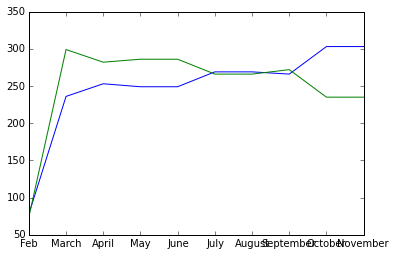

In [253]:
x= [0,1,2,3,4,5,6,7,8,9]
plt.plot(x, ds)
plt.plot(x, rs)
plt.xticks(x, months)

In [232]:
df12['Date'] = df12['Date'].str.replace('-', ' ')

In [234]:
df12['Date'] = pd.to_datetime(df12['Date'], format='%b %d')

In [254]:
months = ['Jan', 'Feb', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November']
ds = []
rs = []
for i in range(len(months)):
    if (i+5) < 10:  #formatting
        datestring = '1900-0' + str(i+1) + '-15 00:00:00'
    else:
        datestring = '1900-' + str(i+1) + '-15 00:00:00'
    #datestring = '1900-15-' + str(i+5) + ' 00:00:00'
    df12b = df12[df12['Date'] < datestring]   #df of all polls prior to this date
    #print df12b.shape
    df12b = df12b.groupby('State').mean()  #get mean by state
    #assign all R and D votes to highest polling candidate by state 
    df12b['DemVotes'] = 0
    df12b['GOPVotes'] = 0
    df12b['DemVotes'] = np.where(df12b['Dem'] > df12b['GOP'], df12b['Votes'], 0)
    df12b['GOPVotes'] = np.where(df12b['Dem'] < df12b['GOP'], df12b['Votes'], 0)
    ds.append(df12b['DemVotes'].sum())  #sum total predicted dem and republican votes
    rs.append(df12b['GOPVotes'].sum())
    #print ds

([<matplotlib.axis.XTick at 0x10c4a68d0>,
 <a list of 11 Text xticklabel objects>)

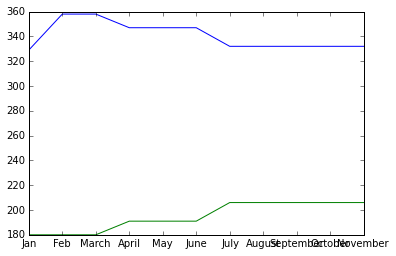

In [255]:
x= [0,1,2,3,4,5,6, 7,8,9,10]
plt.plot(x, ds)
plt.plot(x, rs)
plt.xticks(x, months)

## Improving the Model
This was a dumb model, but it showed some promise. Let's try a few things to improve the model. 

A few strategies to try:

* Decaying importance of older polls in favor of newer ones 
* Defaulting states to their historical party preference for dates prior to their first poll that we have on record